In [61]:
pip install category_encoders

In [5]:
import csv
import os
import sys
from collections import defaultdict

# Dask imports
import dask.dataframe as df  # Dask dataframes
from csv import reader

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split

sns.set_style('whitegrid') # sets the visual style of Seaborn plots to 'whitegrid', which displays a white background with grid lines.
sns.set_palette('pastel')  # sets the color palette to 'pastel', which is one of the predefined color palettes provided by Seaborn. It consists of a set of visually distinct colors suitable for plotting categorical data.



Mounted at /content/gdrive


In [7]:
# Mount Google Drive
from google.colab import drive #used to access files
drive.mount('/content/gdrive')

data_dir_train  = 'gdrive/My Drive/creditcard_data/fraudTrain.csv'
data_dir_test  = 'gdrive/My Drive/creditcard_data/fraudTest.csv'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [18]:
# Read CSV files into Dask DataFrames
train_df = df.read_csv(data_dir_train)
train_df = train_df.set_index('Unnamed: 0')
test_df = df.read_csv(data_dir_test)
test_df.set_index('Unnamed: 0')

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
npartitions=2,,,,,,,,,,,,,,,,,,,,,,
0,object,int64,object,object,float64,object,object,object,object,object,object,int64,float64,float64,int64,object,object,object,int64,float64,float64,int64
278054,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555718,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [13]:
train_df.head(3)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0


In [19]:
train_df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 22 entries, trans_date_trans_time to is_fraud
dtypes: object(12), float64(5), int64(5)

In [28]:
# Count the total number of missing values in the DataFrame
missing_values_count = train_df.isna().sum().sum().compute()
print("Total missing values:", missing_values_count)

Total missing values: 0


In [43]:
# Count the duplicate rows in the DataFrame
duplicate_rows_count = train_df.groupby(train_df.columns.tolist()).size().reset_index()

# Filter out rows with count > 1 to get duplicate rows
duplicate_rows = duplicate_rows_count[duplicate_rows_count[0] > 1]

# Count the total number of duplicate rows
total_duplicate_rows_count = len(duplicate_rows)

# Display the count of duplicate rows
print("Total count of duplicate rows:", total_duplicate_rows_count)

Total count of duplicate rows: 0


Each transaction has it's own number

In [20]:
# Calculate value counts for "is_fraud" column
is_fraud = train_df["is_fraud"].value_counts()

# Trigger computation and retrieve results
is_fraud_result = is_fraud.compute()

# Print the counts
print("Yes:", is_fraud_result[1])
print("No:", is_fraud_result[0])

Yes: 7506
No: 1289169


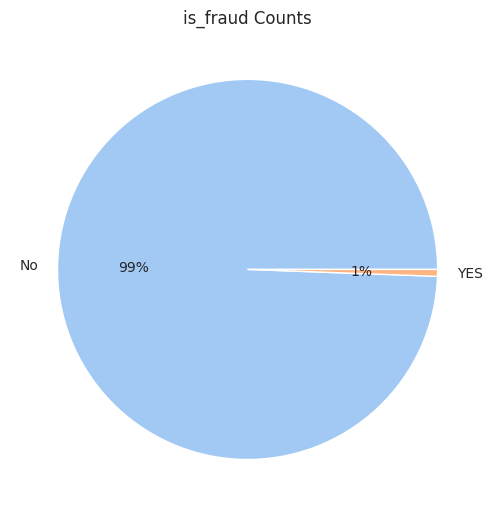

In [46]:
is_fraud = train_df["is_fraud"].value_counts()
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)  # Subplot for the pie chart
plt.pie(is_fraud, labels=["No", "YES"], autopct="%0.0f%%")
plt.title("is_fraud Counts")
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

Data is unbalanced, we will undersample the majority class

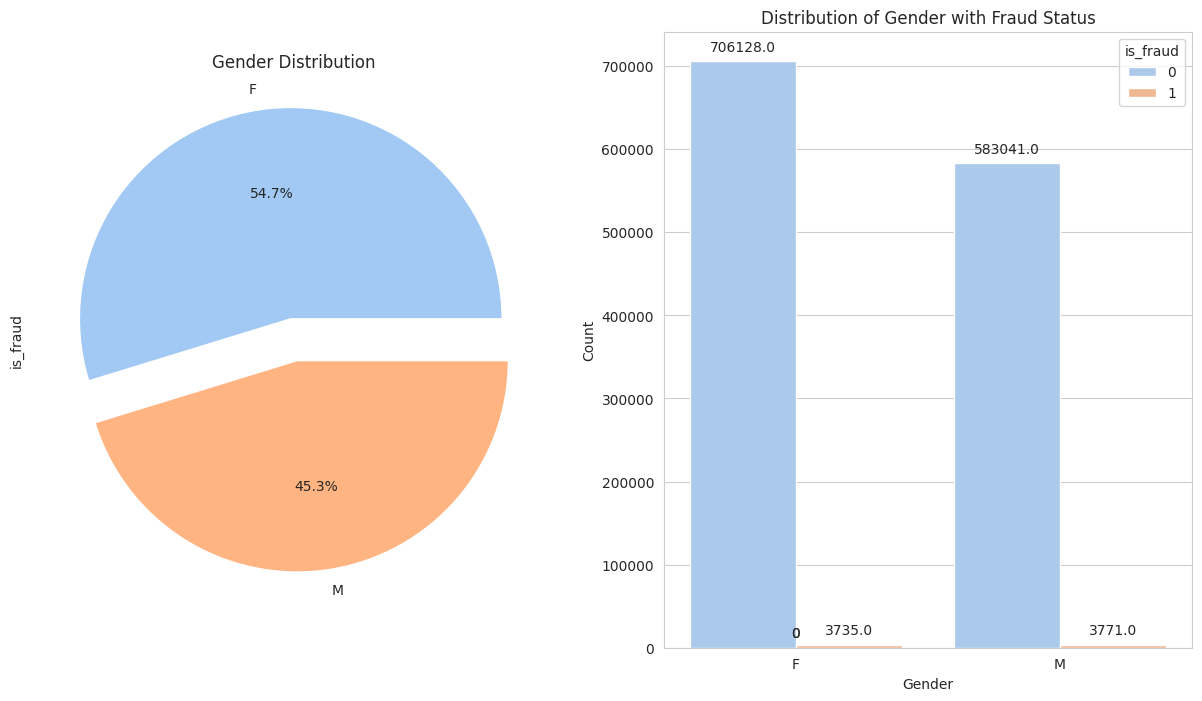

In [45]:
# Create subplots
fig, axb = plt.subplots(ncols=2, nrows=1, figsize=(15, 8))

# Gender Distribution Pie Chart
explode = [0.1, 0.1]
train_df.groupby('gender')['is_fraud'].count().compute().plot.pie(explode=explode, autopct="%1.1f%%", ax=axb[0])
axb[0].set_title("Gender Distribution")

# Gender Distribution Count Plot
ax = sns.countplot(x="gender", hue="is_fraud", data=train_df.compute(), ax=axb[1])

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
axb[1].set_title("Distribution of Gender with Fraud Status")
axb[1].set_xlabel("Gender")
axb[1].set_ylabel("Count")

# Show the plot
plt.show()

Females make more transactions however commit less fraudulent transactions when compared to males

FEATURE ENGINEERING

In [49]:
# Change date type from object to datetime
train_df['trans_date_trans_time'] = df.to_datetime(train_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')
test_df['trans_date_trans_time'] = df.to_datetime(test_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

In [50]:
train_df['hour'] = train_df['trans_date_trans_time'].dt.hour
test_df['hour'] = test_df['trans_date_trans_time'].dt.hour

train_df['month'] = train_df['trans_date_trans_time'].dt.month
test_df['month'] = test_df['trans_date_trans_time'].dt.month

train_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,month
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,1
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,1
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,1
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,1
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,1


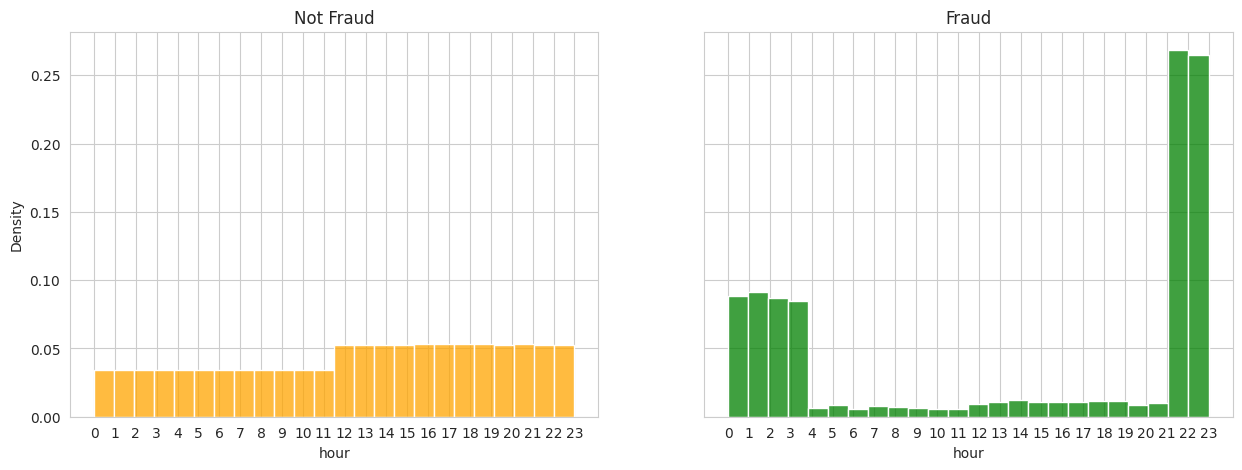

In [52]:
# Convert Dask DataFrame to Pandas DataFrame for plotting
train_df_pd = train_df.compute()

# Create subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)

# Plot histogram for non-fraud transactions
sns.histplot(x='hour', data=train_df_pd[train_df_pd["is_fraud"] == 0],
             stat="density", bins=24, ax=ax1, color="orange")
ax1.set_title("Not Fraud")
ax1.set_xticks(np.arange(24))  # ticks of the day 0 -> 23

# Plot histogram for fraud transactions
sns.histplot(x='hour', data=train_df_pd[train_df_pd["is_fraud"] == 1],
             stat="density", bins=24, ax=ax2, color="green")
ax2.set_title("Fraud")
ax2.set_xticks(np.arange(24))  # ticks of the day 0 -> 23

plt.show()

We observe that fraudulent transactions more often occur during the last 2 hours of the day

DATA PREPROCESSING

In [54]:
# remove non-useful columns
columns_to_drop = ['first', 'unix_time', 'dob', 'cc_num', 'zip', 'city','street', 'state', 'trans_num', 'trans_date_trans_time']
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)
train_df.head(2)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
Unnamed: 0,,,,,,,,,,,,,,
0,"fraud_Rippin, Kub and Mann",misc_net,4.97,Banks,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,0,1
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Gill,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,0,1


In [56]:
# #clean merchant column
# train_df['merchant'] = train_df['merchant'].apply(lambda x : x.replace('fraud_',''))

# Define a function to clean the 'merchant' column
def clean_merchant(x):
    return x.str.replace('fraud_', '')

# Define the meta parameter with the expected output type
meta = ('merchant', 'object')

# Apply the cleaning function to the 'merchant' column
train_df['merchant'] = train_df['merchant'].map_partitions(clean_merchant, meta=meta)

# Persist the changes
train_df = train_df.persist()

In [57]:
train_df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 14 entries, merchant to month
dtypes: object(5), float64(5), int64(4)

In [58]:
train_df.head(2)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
Unnamed: 0,,,,,,,,,,,,,,
0,"Rippin, Kub and Mann",misc_net,4.97,Banks,F,36.0788,-81.1781,3495,"Psychologist, counselling",36.011293,-82.048315,0,0,1
1,"Heller, Gutmann and Zieme",grocery_pos,107.23,Gill,F,48.8878,-118.2105,149,Special educational needs teacher,49.159047,-118.186462,0,0,1


DATA ENCODING

In [81]:
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder

def encode_partition(partition):
    encoder = LabelEncoder()
    partition = partition.fillna('missing')  # Fill missing values if any
    for col in partition.columns:
        if pd.api.types.is_string_dtype(partition[col]):
            partition[col] = encoder.fit_transform(partition[col])
    return partition

def encode(df):
    encoders = {}
    encoded_df = df.map_partitions(encode_partition)
    with open('LE_mdl_v1.pkl', 'wb') as f:
        pickle.dump(encoders, f)
    return encoded_df

train = encode(train_df)

In [82]:
train.head(2)

,merchant,category,amt,last,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,hour,month
Unnamed: 0,,,,,,,,,,,,,,
0,514,8,4.97,18,0,36.0788,-81.1781,3495,360,36.011293,-82.048315,0,0,1
1,241,4,107.23,155,0,48.8878,-118.2105,149,416,49.159047,-118.186462,0,0,1
